## How to cryo EM

In this tutorial, we demonstrate how to load a protein model in .mrc format, apply the differntiable backprojection to it, use the generative model to learn a latent distribution.

For this, we load essential libraries and specify the cuda input device.

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from numpy import random
import torch
from torch import distributions
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

from observation_model import ScientificImagingObservationModel

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

We next load the XX protein [1]. Note that for this we use some third party code [2]. 
We confige the total mass "total_mass" of the protein and the extent of the observations D manually.

In [2]:
from third_party import readMRC, compute_premultiplier, real_to_fspace, window, fspace_to_real


def load_protein(path, total_mass, D):
    M = readMRC(path)
    kernel = 'linear'
    ksize = 2
    premult = compute_premultiplier(D, kernel, ksize)
    premult = premult.reshape((1, 1, -1)) * premult.reshape((1, -1, 1)) * premult.reshape((-1, 1, 1))
    window(M, 'circle')
    M[M < 0] = 0
    if total_mass is not None:
        M *= float(total_mass) / M.sum()
    structure = real_to_fspace(M * premult)
    structure = np.concatenate((np.array(structure.real, ndmin=4).T, np.array(structure.imag, ndmin=4).T), axis=3)
    return torch.tensor(structure).unsqueeze(0).permute(0, 4, 1, 2, 3)


D = 128
protein = load_protein(path="./proteins/1AON.mrc", total_mass=80000, D=D).to(device)

ERROR LOADING FFTW! USING NUMPY


We next specify some random position and project the protein constrain to this poition:

In [3]:
# generate random poistion
from operators import rotmat3D_EA

rotation = torch.rand((1, 3)).to(device)
rotation_representation = rotmat3D_EA(rotation)
translation = torch.rand((1, 2)).to(device) * 0.2

# load observation model
from observation_model import ScientificImagingObservationModel

observation_model = ScientificImagingObservationModel(D=D, std_noise=0.).to(device)

# get projection
projection, _ = observation_model(protein, rotation_representation, translation)


/home/karen/devtools/miniconda2/envs/backprojection/lib/python3.6/site-packages/torch/tensor.py:339: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Finally lets look at the projections, in real and fourier space:

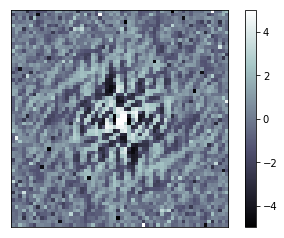

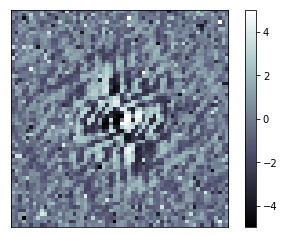

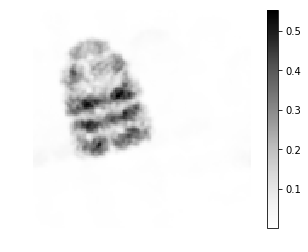

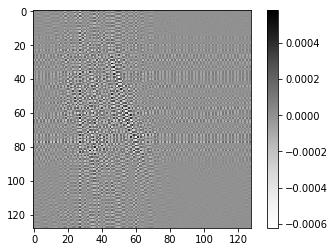

In [4]:
import utils

utils.save_imag(projection[0, 0], name="projection_real", logsclae=True, vmax=5, vmin=-5, centercrop=30, save=False)
utils.save_imag(projection[0, 1], name="projection_real", logsclae=True, vmax=5, vmin=-5, centercrop=30, save=False)
utils.save_real_imag(projection, save=False)

Using this technique we can generate a small dataset of simulated projections, these shall have some noise 

In [5]:
observation_model = ScientificImagingObservationModel(D=D, std_noise=0.).to(device)

num_data_points = 4096

observations, rotation_representations, translations = [], [], []

for i in range(num_data_points):
    rotations = torch.rand((1, 3)).to(device)
    rotation_representation = rotmat3D_EA(rotations)
    translation = torch.rand((1, 2)).to(device) * 0.2
    rotation_representations.append(rotation_representation)
    translations.append(translation)

    projection, _ = observation_model(protein, rotation_representation, translation)
    projection = projection.cpu().numpy()
    observations.append(fspace_to_real(projection))

In [6]:
protein_loc = nn.Parameter(torch.Tensor(2, D, D, D).to(device), requires_grad=True)
protein_log_scale = nn.Parameter(torch.Tensor(2, D, D, D).to(device), requires_grad=True)

# init params
protein_loc.data.fill_(0.)
protein_log_scale.data.fill_(-1)

print()

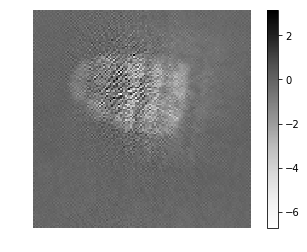

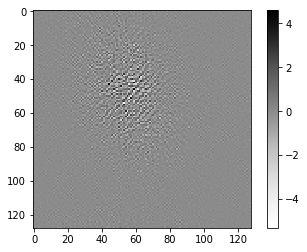

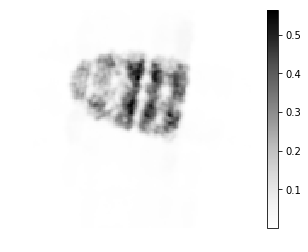

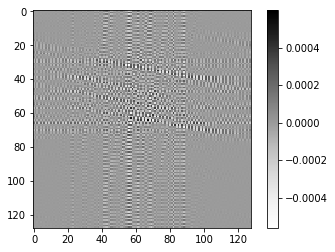

In [12]:
num_iterations = int(1e3)


def optimizer_grad_step(optimizer):
    for opt in optimizer:
        opt.step()
        opt.zero_grad()
    return optimizer


optimizer = []
optimizer.append(optim.Adam([protein_loc], lr=2., betas=(0.8, 0.999)))
optimizer.append(optim.Adam([protein_log_scale], lr=0.01, betas=(0.8, 0.999)))


def create_radial_mask(shape, radius=None):
    N = shape[0]
    radius -= 1.
    if radius < 0.:
        return np.zeros(shape) * 1.0

    elif radius is None:
        radius = int(N / 2)

    a, b = N / 2, N / 2
    y, x = np.ogrid[-a:N - a, -b:N - b]
    mask = x * x + y * y <= radius * radius

    return mask * np.ones(shape) * 1.0

mask = torch.Tensor(create_radial_mask((D, D), int(D / 2))).to(device)

num_pixels = mask.sum()


def real2fourier(observation):
    image = real_to_fspace(observation[0,0])
    image *= np.sqrt(D) 
    real_part = np.expand_dims(image.real, 0)
    imag_part = np.expand_dims(image.imag, 0)
    return np.expand_dims(np.vstack([real_part, imag_part]), 0)


for iteration in range(num_iterations):
    idx = random.randint(0, num_data_points)
    protein_dist = distributions.Normal(loc=protein_loc, scale=F.softplus(protein_log_scale))
    protein_sample = protein_dist.rsample((1,))
    projection, observation_dist = observation_model(protein_sample, rotation_representations[idx], translations[idx])

    observation = torch.Tensor(real2fourier(observations[idx])).to(device)
    conditional_loglikelihood = observation_dist.log_prob(observation).sum() / num_pixels
    loss = -conditional_loglikelihood
    loss.backward()
    optimizer_grad_step(optimizer)

    # compare learned volume to data generating one
    MSE = F.mse_loss(protein_loc, protein[0]).detach().cpu().numpy()
    print("Iteration {}/{}, MSE: {}".format(iteration, num_iterations, MSE), end='\r', flush=True)

projection, _ = observation_model(protein_sample, rotation_representations[idx], translations[idx])
utils.save_real_imag(projection, save=False)
projection, _ = observation_model(protein, rotation_representations[idx], translations[idx])
utils.save_real_imag(projection, save=False)